In [1]:
%matplotlib inline
from matplotlib import style, patches
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import mdates for date formatting
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to the classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
with Session(engine) as session:
    # Your session-related code will go here
    pass

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {most_recent_date}")

Most recent date: 2017-08-23


Date One year from the last date: 2016-08-23


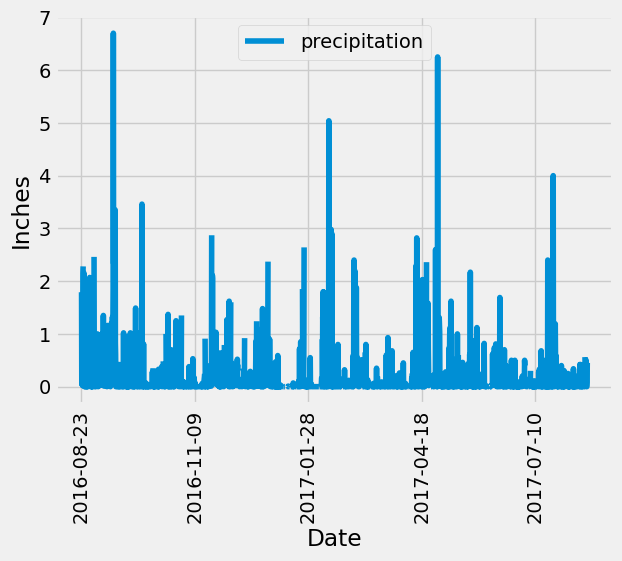

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
print(f"Date One year from the last date: {one_year_ago.date()}")

# Perform a query to retrieve the data and precipitation scores
precipitation_results = session.query(Measurement.date, Measurement.prcp.label("precipitation")).filter(
        Measurement.date >= one_year_ago.date()
    ).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_results, columns=["date", "precipitation"])
precipitation_df.set_index("date", inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Plot the precipitation data
ax = precipitation_df.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
plt.xticks(rotation=90)  # Rotate x-axis dates vertically
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precipitation_df.describe())


       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
with Session(engine) as session:
    total_stations = session.query(func.count(Measurement.station.distinct())).scalar()
    print(f" [( {total_stations} ,)]")


 [( 9 ,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
with Session(engine) as session:
    active_stations = session.query(
        Measurement.station, 
        func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

    for station, count in active_stations:
        print(f"('{station}', {count})")
    #print("\n")  # Add a newline for clarity


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

with Session(engine) as session:
    active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    most_active_station = active_stations[0][0]
    #print(f"Most active station: {most_active_station}")

# Calculate temperature statistics for the most-active station
    temperature_stats = session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    ).filter(Measurement.station == most_active_station).all()

# Extract the temperature statistics
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


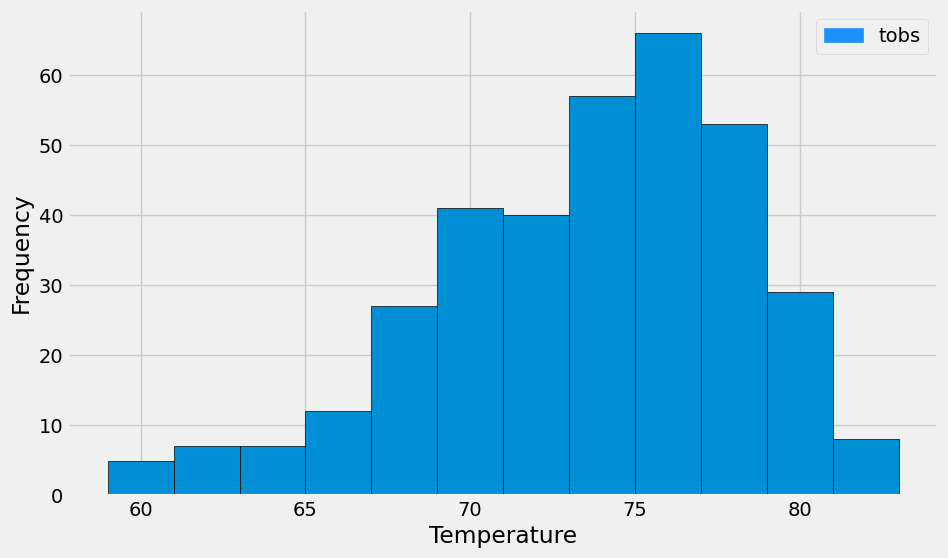

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = active_stations[0][0]
#print(f"Most active station: {most_active_station}")

# Perform a query to retrieve the temperature observation data for the last 12 months
tobs_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago.date()).all()

# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["date", "tobs"])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(tobs_df["tobs"], bins=12, edgecolor='black')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
blue_patch = patches.Patch(color='dodgerblue', label='tobs')
plt.legend(handles=[blue_patch], loc='upper right')
plt.show()




# Close Session

In [16]:
# Close Session
session.close()